# Multi-Agent System with LangGraph

This notebook provides a detailed walkthrough of the `multi_agent_prebuilt.py` script. We will explore how to build multi-agent systems using LangGraph, specifically focusing on Supervisor and Swarm patterns, as well as custom handoffs between agents.

**Overview of the `multi_agent_prebuilt.py` script:**

The script demonstrates three different approaches to building multi-agent systems:
1.  **Supervisor Pattern:** A central supervisor agent delegates tasks to specialized agents.
2.  **Swarm Pattern:** Agents can hand off tasks to each other directly.
3.  **Custom Handoffs:** A more granular implementation of agent-to-agent task handoffs.

## Section 1: Setup and Imports

This section handles the initial setup, including loading environment variables for API keys and importing necessary libraries. The `dotenv` library is used to load the `OPENAI_API_KEY` from a `.env` file. `rich` is used for pretty-printing outputs.

In [5]:
import os
from dotenv import load_dotenv
from rich import print
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
load_dotenv()
# Make sure to set your OPENAI_API_KEY in a .env file or as an environment variable

True

## Section 2: Supervisor Multi-Agent System

This example demonstrates a supervisor-worker architecture. A `supervisor` agent receives a user request and routes it to the appropriate specialized agent (`flight_assistant` or `hotel_assistant`).

**Code Logic:**
1.  **Tool Definition:** Simple functions `book_hotel` and `book_flight` are defined as tools for the agents.
2.  **Agent Creation:** Two `create_react_agent` instances are created. Each agent is specialized for a single task (booking flights or hotels) and is given access to the relevant tool.
3.  **Supervisor Creation:** `create_supervisor` is used to create a managing agent that orchestrates the two specialized agents.
4.  **Execution:** The system is run by streaming a user request through the compiled supervisor graph.

In [6]:
def book_hotel(hotel_name: str):
    """Book a hotel"""
    return f'Successfully booked a stay at {hotel_name}.'

def book_flight(from_airport: str, to_airport: str):
    """Book a flight"""
    return f'Successfully booked a flight from {from_airport} to {to_airport}.'


In [7]:

# Create specialized agents
flight_assistant = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_flight],
    prompt='You are a flight booking assistant. Help users book flights.',
    name='flight_assistant',
)

hotel_assistant = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_hotel],
    prompt='You are a hotel booking assistant. Help users book hotels.',
    name='hotel_assistant',
)

# Create supervisor
supervisor = create_supervisor(
    agents=[flight_assistant, hotel_assistant],
    model=ChatOpenAI(model='gpt-4o-mini'),
    prompt='You manage hotel and flight booking assistants. Assign work to them.',
).compile()



Subgraph structure:

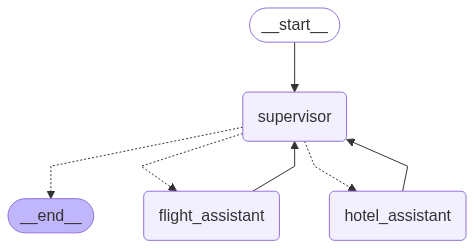

In [8]:
print('Subgraph structure:')
# Optional: Display a visualization of the graph's structure.
try:
    from IPython.display import Image, display

    display(Image(supervisor.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
print('=== SUPERVISOR EXAMPLE ===')
for chunk in supervisor.stream({'messages': [{'role': 'user', 'content': 'Book a flight from LAX to NYC'}]}, debug=True):
    if chunk:
        print('-'*60)
        print(f'Chunk: {chunk}')
        # print(chunk)

=== SUPERVISOR EXAMPLE ===

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='9ed9a4eb-9c5f-47b5-85f7-384714458098')]}
[updates] {'supervisor': {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='9ed9a4eb-9c5f-47b5-85f7-384714458098'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm', 'service_

------------------------------------------------------------

{
    'supervisor': {
        'messages': [
            HumanMessage(
                content='Book a flight from LAX to NYC',
                additional_kwargs={},
                response_metadata={},
                id='9ed9a4eb-9c5f-47b5-85f7-384714458098'
            ),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD',
                            'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'},
                            'type': 'function'
                        }
                    ],
                    'refusal': None
                },
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 14,
                        'prompt_tokens': 88,
                        'total_tokens': 102,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm',
                    'service_tier': 'default',
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                name='supervisor',
                id='run--58485db1-e893-4987-9ed2-e722fe0e2e7d-0',
                tool_calls=[
                    {
                        'name': 'transfer_to_flight_assistant',
                        'args': {},
                        'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 88,
                    'output_tokens': 14,
                    'total_tokens': 102,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            ToolMessage(
                content='Successfully transferred to flight_assistant',
                name='transfer_to_flight_assistant',
                id='93b60984-71cd-4243-be44-b53f1ec5e93e',
                tool_call_id='call_wX5sPVk8BUZ6Cs6m5KZfKORD'
            )
        ]
    }
}

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='9ed9a4eb-9c5f-47b5-85f7-384714458098'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--58485db1-e893-4987-9ed2-e722fe0e2e7d-0', tool_calls=[{'name': 'transfer_to_flight_assi

------------------------------------------------------------

{
    'flight_assistant': {
        'messages': [
            AIMessage(
                content='Your flight from LAX to NYC has been successfully booked! If you need any further 
assistance, feel free to ask.',
                additional_kwargs={'refusal': None},
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 25,
                        'prompt_tokens': 153,
                        'total_tokens': 178,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCbPxsAGntkjr0LHun9bboa2Fq9VG',
                    'service_tier': 'default',
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                name='flight_assistant',
                id='run--4a9365c0-d7c2-4292-a2a4-fe932a84fb40-0',
                usage_metadata={
                    'input_tokens': 153,
                    'output_tokens': 25,
                    'total_tokens': 178,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            AIMessage(
                content='Transferring back to supervisor',
                additional_kwargs={},
                response_metadata={'__is_handoff_back': True},
                name='flight_assistant',
                id='9b140371-4773-4b29-a4b8-d9a2c1073069',
                tool_calls=[
                    {
                        'name': 'transfer_back_to_supervisor',
                        'args': {},
                        'id': 'f74045b1-70f4-49d9-86bb-e571d6fe6d42',
                        'type': 'tool_call'
                    }
                ]
            ),
            ToolMessage(
                content='Successfully transferred back to supervisor',
                name='transfer_back_to_supervisor',
                id='50ee2976-4f08-46e5-8b85-41cdad13a72f',
                tool_call_id='f74045b1-70f4-49d9-86bb-e571d6fe6d42'
            )
        ]
    }
}

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='9ed9a4eb-9c5f-47b5-85f7-384714458098'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--58485db1-e893-4987-9ed2-e722fe0e2e7d-0', tool_calls=[{'name': 'transfer_to_flight_assi

------------------------------------------------------------

{
    'supervisor': {
        'messages': [
            HumanMessage(
                content='Book a flight from LAX to NYC',
                additional_kwargs={},
                response_metadata={},
                id='9ed9a4eb-9c5f-47b5-85f7-384714458098'
            ),
            AIMessage(
                content='',
                additional_kwargs={
                    'tool_calls': [
                        {
                            'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD',
                            'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'},
                            'type': 'function'
                        }
                    ],
                    'refusal': None
                },
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 14,
                        'prompt_tokens': 88,
                        'total_tokens': 102,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm',
                    'service_tier': 'default',
                    'finish_reason': 'tool_calls',
                    'logprobs': None
                },
                name='supervisor',
                id='run--58485db1-e893-4987-9ed2-e722fe0e2e7d-0',
                tool_calls=[
                    {
                        'name': 'transfer_to_flight_assistant',
                        'args': {},
                        'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD',
                        'type': 'tool_call'
                    }
                ],
                usage_metadata={
                    'input_tokens': 88,
                    'output_tokens': 14,
                    'total_tokens': 102,
                    'input_token_details': {'audio': 0, 'cache_read': 0},
                    'output_token_details': {'audio': 0, 'reasoning': 0}
                }
            ),
            ToolMessage(
                content='Successfully transferred to flight_assistant',
                name='transfer_to_flight_assistant',
                id='93b60984-71cd-4243-be44-b53f1ec5e93e',
                tool_call_id='call_wX5sPVk8BUZ6Cs6m5KZfKORD'
            ),
            AIMessage(
                content='Your flight from LAX to NYC has been successfully booked! If you need any further 
assistance, feel free to ask.',
                additional_kwargs={'refusal': None},
                response_metadata={
                    'token_usage': {
                        'completion_tokens': 25,
                        'prompt_tokens': 153,
                        'total_tokens': 178,
                        'completion_tokens_details': {
                            'accepted_prediction_tokens': 0,
                            'audio_tokens': 0,
                            'reasoning_tokens': 0,
                            'rejected_prediction_tokens': 0
                        },
                        'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}
                    },
                    'model_name': 'gpt-4o-mini-2024-07-18',
                    'system_fingerprint': 'fp_8bda4d3a2c',
                    'id': 'chatcmpl-CCbPxsAGntkjr0LHun9bboa2Fq9VG',
                    'service_tier': 'default',
                    'finish_reason': 'stop',
                    'logprobs': None
                },
                name='flight_assistant',
                id='run--4a9365c0-d7c2-4292-a2a4-fe9

[values] {'messages': [HumanMessage(content='Book a flight from LAX to NYC', additional_kwargs={}, response_metadata={}, id='9ed9a4eb-9c5f-47b5-85f7-384714458098'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wX5sPVk8BUZ6Cs6m5KZfKORD', 'function': {'arguments': '{}', 'name': 'transfer_to_flight_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 88, 'total_tokens': 102, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbPvHJGSdUcy1Zx7l8JXvF9VSNBm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervisor', id='run--58485db1-e893-4987-9ed2-e722fe0e2e7d-0', tool_calls=[{'name': 'transfer_to_flight_assi

## Section 3: Swarm Multi-Agent System

This example showcases a swarm architecture where agents can directly hand off tasks to one another. This is useful for more collaborative workflows.

**Code Logic:**
1.  **Tool Definition:** Similar to the supervisor example, `book_hotel_swarm` and `book_flight_swarm` are defined.
2.  **Handoff Tool Creation:** `create_handoff_tool` is used to create special tools that allow one agent to transfer control to another.
3.  **Agent Creation:** Agents are created with both their primary tool and the handoff tools.
4.  **Swarm Creation:** `create_swarm` assembles the agents into a collaborative system. A `default_active_agent` is specified to handle the initial user request.
5.  **Execution:** The user request is streamed through the swarm.

In [12]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_swarm, create_handoff_tool

# Define booking tools
def book_hotel_swarm(hotel_name: str):
    """Book a hotel"""
    return f'Hotel booked: {hotel_name}'

def book_flight_swarm(from_airport: str, to_airport: str):
    """Book a flight"""
    return f'Flight booked: {from_airport} to {to_airport}'


In [20]:

# Create handoff tools
transfer_to_hotel = create_handoff_tool(
    agent_name='hotel_assistant',
    description='Transfer to hotel booking assistant.',
)

transfer_to_flight = create_handoff_tool(
    agent_name='flight_assistant',
    description='Transfer to flight booking assistant.',
)

# Create agents
flight_assistant_swarm = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_flight_swarm, transfer_to_hotel],
    prompt='You are a flight booking assistant.',
    name='flight_assistant',
)

hotel_assistant_swarm = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_hotel_swarm, transfer_to_flight],
    prompt='You are a hotel booking assistant.',
    name='hotel_assistant',
)



Subgraph structure:

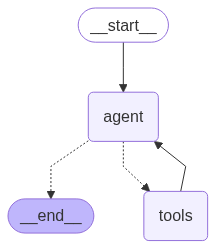

In [21]:

print('Subgraph structure:')
# Optional: Display a visualization of the graph's structure.
try:
    from IPython.display import Image, display

    display(Image(hotel_assistant_swarm.get_graph().draw_mermaid_png()))
except Exception:
    pass


In [ ]:

# Create swarm
swarm = create_swarm(agents=[flight_assistant_swarm, hotel_assistant_swarm], default_active_agent='flight_assistant').compile()

print('\n=== SWARM EXAMPLE ===')
for chunk in swarm.stream({'messages': [{'role': 'user', 'content': 'Book a hotel at Marriott'}]}, debug=True):
    if chunk:
        print('-'*60)
        print(f'Chunk: {chunk}')
        # print(chunk)

=== SWARM EXAMPLE ===

Chunk: {'flight_assistant': {'messages': [HumanMessage(content='Book a hotel at Marriott', additional_kwargs={}, 
response_metadata={}, id='2e73fe94-11bd-42e8-a312-4f7205d15f40'), AIMessage(content='', 
additional_kwargs={'tool_calls': [{'id': 'call_sx0Hk47amk6ZVPmWb7yV7Wfi', 'function': {'arguments': '{}', 'name': 
'transfer_to_hotel_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': 
{'completion_tokens': 14, 'prompt_tokens': 82, 'total_tokens': 96, 'completion_tokens_details': 
{'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 
'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 
'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbMIhtTJVZxmmBFVLlIqujJAVWZ7', 'service_tier': 'default', 
'finish_reason': 'tool_calls', 'logprobs': None}, name='flight_assistant', 
id='run--9e779eab-9863-4b4e-b70c-478dc7add635-0', tool_calls=[{'name': 'transfer_to_hotel_assistant', 'args': {}, 
'id': 'call_sx0Hk47amk6ZVPmWb7yV7Wfi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 
14, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 
'reasoning': 0}}), ToolMessage(content='Successfully transferred to hotel_assistant', 
name='transfer_to_hotel_assistant', id='5fa5e71a-6a4d-4561-8728-ebfe03e2a473', 
tool_call_id='call_sx0Hk47amk6ZVPmWb7yV7Wfi')], 'active_agent': 'hotel_assistant'}}

Chunk: {'hotel_assistant': {'messages': [HumanMessage(content='Book a hotel at Marriott', additional_kwargs={}, 
response_metadata={}, id='2e73fe94-11bd-42e8-a312-4f7205d15f40'), AIMessage(content='', 
additional_kwargs={'tool_calls': [{'id': 'call_sx0Hk47amk6ZVPmWb7yV7Wfi', 'function': {'arguments': '{}', 'name': 
'transfer_to_hotel_assistant'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': 
{'completion_tokens': 14, 'prompt_tokens': 82, 'total_tokens': 96, 'completion_tokens_details': 
{'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 
'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 
'system_fingerprint': 'fp_8bda4d3a2c', 'id': 'chatcmpl-CCbMIhtTJVZxmmBFVLlIqujJAVWZ7', 'service_tier': 'default', 
'finish_reason': 'tool_calls', 'logprobs': None}, name='flight_assistant', 
id='run--9e779eab-9863-4b4e-b70c-478dc7add635-0', tool_calls=[{'name': 'transfer_to_hotel_assistant', 'args': {}, 
'id': 'call_sx0Hk47amk6ZVPmWb7yV7Wfi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 82, 'output_tokens': 
14, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 
'reasoning': 0}}), ToolMessage(content='Successfully transferred to hotel_assistant', 
name='transfer_to_hotel_assistant', id='5fa5e71a-6a4d-4561-8728-ebfe03e2a473', 
tool_call_id='call_sx0Hk47amk6ZVPmWb7yV7Wfi'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 
'call_T0tBl6AY0BCSPDv4ylS65zXv', 'function': {'arguments': '{"hotel_name":"Marriott"}', 'name': 
'book_hotel_swarm'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': 
{'completion_tokens': 19, 'prompt_tokens': 111, 'total_tokens': 130, 'completion_tokens_details': 
{'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 
'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 
'system_fingerprint': 'fp_e665f7564b', 'id': 'chatcmpl-CCbMJJFP8JgFfZQbkOqwe08KY88Cs', 'service_tier': 'default', 
'finish_reason': 'tool_calls', 'logprobs': None}, name='hotel_assistant', 
id='run--7eb36267-8e20-4573-a174-6db936a84031-0', tool_calls=[{'name': 'book_hotel_swarm', 'args': {'hotel_name': 
'Marriott'}, 'id': 'call_T0tBl6AY0BCSPDv4ylS65zXv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 111, 
'output_tokens': 19, 'total_tokens': 130, 'input_token_details': {'audio': 0, 'cache_read': 0}, 
'output_token_details': {'audio': 0, 'reasoning': 0}}), ToolMessage(content='Hotel booked: Marriott', 
name='book_hotel_swarm', id='d76cc101-3d3e-4448-8017-61aaa18bd92c', tool_call_id='call_T0tBl6AY0BCSPDv4ylS65zXv'), 
AIMessage(content='Your hotel at Marriott has been successfully booked! If you need any further assistance, feel 
free to ask.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 
'prompt_tokens': 149, 'total_tokens': 171, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 
'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': 
{'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 
'fp_e665f7564b', 'id': 'chatcmpl-CCbMJM3f6646RghAD1QGp7GYArChx', 'service_tier': 'default', 'finish_reason': 
'stop', 'logprobs': None}, name='hotel_assistant', id='run--7ec9d6ed-281e-4662-b248-f8e3e008dce8-0', 
usage_metadata={'input_tokens': 149, 'output_tokens': 22, 'total_tokens': 171, 'input_token_details': {'audio': 0, 
'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}}

## Section 4: Custom Handoffs Implementation

This section provides a from-scratch implementation of handoffs, giving you more control over the agent interaction logic. It uses a `StateGraph` to define the workflow explicitly.

**Code Logic:**
1.  **Tool Definition:** `book_hotel_custom` and `book_flight_custom` are defined.
2.  **Custom Handoff Tool Factory:** A function `create_handoff_tool` is created. This factory generates a tool that, when called, returns a `Command` object. This `Command` instructs the graph to transition to a different agent node.
3.  **Agent Definition:** Agents are created with their respective tools, including the custom handoff tools.
4.  **Graph Building:** A `StateGraph` is constructed. The agents are added as nodes, and an entry point (`START`) is defined, directing initial requests to the `flight_assistant`.

In [16]:
from typing import Annotated
from langchain_core.tools import tool, InjectedToolCallId
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent, InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command

# Define booking tools
def book_hotel_custom(hotel_name: str):
    """Book a hotel"""
    return f'Custom hotel booking: {hotel_name}'

def book_flight_custom(from_airport: str, to_airport: str):
    """Book a flight"""
    return f'Custom flight booking: {from_airport} to {to_airport}'


In [17]:

# Custom handoff tool factory
def create_handoff_tool_custom(*, agent_name: str, description: str):
    name = f'transfer_to_{agent_name}'

    @tool(name, description=description)
    def handoff_tool(
        state: Annotated[MessagesState, InjectedState],
        tool_call_id: Annotated[str, InjectedToolCallId],
    ) -> Command:
        tool_message = {
            'role': 'tool',
            'content': f'Transferred to {agent_name}',
            'name': name,
            'tool_call_id': tool_call_id,
        }
        return Command(
            goto=agent_name,
            update={'messages': state['messages'] + [tool_message]},
            graph=Command.PARENT,
        )

    return handoff_tool


In [18]:

# Create handoff tools
transfer_to_hotel_custom = create_handoff_tool_custom(
    agent_name='hotel_assistant',
    description='Transfer to hotel assistant.',
)

transfer_to_flight_custom = create_handoff_tool_custom(
    agent_name='flight_assistant',
    description='Transfer to flight assistant.',
)

# Define agents
flight_assistant_custom = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_flight_custom, transfer_to_hotel_custom],
    prompt='You are a flight booking assistant.',
    name='flight_assistant',
)

hotel_assistant_custom = create_react_agent(
    model=ChatOpenAI(model='gpt-4o-mini'),
    tools=[book_hotel_custom, transfer_to_flight_custom],
    prompt='You are a hotel booking assistant.',
    name='hotel_assistant',
)

# Build graph
multi_agent_graph = (
    StateGraph(MessagesState)
    .add_node('flight_assistant', flight_assistant_custom)
    .add_node('hotel_assistant', hotel_assistant_custom)
    .add_edge(START, 'flight_assistant')
    .compile()
)


Subgraph structure:

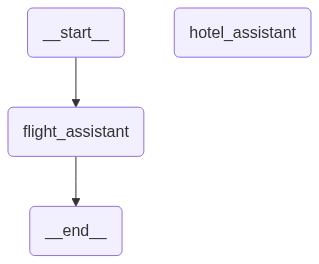

In [19]:

print('Subgraph structure:')
# Optional: Display a visualization of the graph's structure.
try:
    from IPython.display import Image, display

    display(Image(multi_agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:

from regex import P


print('\n=== CUSTOM HANDOFFS EXAMPLE ===')
for chunk in multi_agent_graph.stream({'messages': [{'role': 'user', 'content': 'Book a flight from SFO to LAX'}]}, debug=True):
    if chunk:
        print('-'*60)
        print(f'Chunk: {chunk}')
        # print(chunk)

## Section 5: Conclusion

This notebook has demonstrated three powerful patterns for building multi-agent systems with LangGraph:

-   **Supervisor:** Ideal for hierarchical task delegation where a manager oversees workers.
-   **Swarm:** Suitable for collaborative environments where agents can pass tasks amongst themselves.
-   **Custom Handoffs:** Offers the most flexibility for designing complex, bespoke agent interactions.

**Potential Extensions:**

*   **Error Handling:** Implement more robust error handling within each agent.
*   **Dynamic Routing:** Add more complex conditional logic for routing tasks.
*   **State Management:** Enhance the state to carry more context between agent interactions.